In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yelp-restaurant-photo-classification/train_photos.tgz
/kaggle/input/yelp-restaurant-photo-classification/train.csv.tgz
/kaggle/input/yelp-restaurant-photo-classification/test_photo_to_biz.csv.tgz
/kaggle/input/yelp-restaurant-photo-classification/test_photos.tgz
/kaggle/input/yelp-restaurant-photo-classification/train_photo_to_biz_ids.csv.tgz
/kaggle/input/yelp-restaurant-photo-classification/sample_submission.csv.tgz


In [2]:
import os
import time
import numpy as np
from PIL import Image
from torch.utils.data.dataset import Dataset
from tqdm import tqdm
from torchvision import transforms
from torchvision import models
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import precision_score, recall_score, f1_score
from torch import nn
from torch.utils.data.dataloader import DataLoader
from matplotlib import pyplot as plt
from numpy import printoptions
import requests
import tarfile
import random
import json
from shutil import copyfile

In [3]:
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
torch.backends.cudnn.deterministic = True

In [4]:
import os, sys, tarfile
from tqdm import tqdm
def extract(tar_url, extract_path='.'):
    print(tar_url)
    tar = tarfile.open(tar_url, 'r')
    for item in tqdm(tar):
        tar.extract(item, extract_path)
        if item.name.find(".tgz") != -1 or item.name.find(".tar") != -1:
            extract(item.name, "./" + item.name[:item.name.rfind('/')])

In [5]:
try:
    extract('../input/yelp-restaurant-photo-classification/train_photos' + '.tgz')
    print ('Done.')
except:
    #name = os.path.basename(sys.argv[0])
    print('error')

140it [00:00, 1114.13it/s]

../input/yelp-restaurant-photo-classification/train_photos.tgz


469686it [04:29, 1742.03it/s]


Done.


In [6]:
from tqdm import tqdm
try:
    extract('../input/yelp-restaurant-photo-classification/test_photos.tgz')
    print ('Done.')
except:
    #name = os.path.basename(sys.argv[0])
    print('error')

206it [00:00, 2056.27it/s]

../input/yelp-restaurant-photo-classification/test_photos.tgz


474306it [04:37, 1709.55it/s]

Done.


In [7]:
from tqdm import tqdm
try:
    extract('../input/yelp-restaurant-photo-classification/train.csv.tgz')
    extract('../input/yelp-restaurant-photo-classification/train_photo_to_biz_ids.csv.tgz')
    extract('../input/yelp-restaurant-photo-classification/test_photo_to_biz.csv.tgz')
    extract('../input/yelp-restaurant-photo-classification/sample_submission.csv.tgz')
    print ('Done.')
except:
    #name = os.path.basename(sys.argv[0])
    print('error')

1it [00:00, 544.29it/s]
2it [00:00, 76.50it/s]
0it [00:00, ?it/s]

../input/yelp-restaurant-photo-classification/train.csv.tgz
../input/yelp-restaurant-photo-classification/train_photo_to_biz_ids.csv.tgz
../input/yelp-restaurant-photo-classification/test_photo_to_biz.csv.tgz


1it [00:00,  4.86it/s]
1it [00:00, 358.67it/s]

../input/yelp-restaurant-photo-classification/sample_submission.csv.tgz
Done.


In [8]:
import pandas as pd
train_biz=pd.read_csv('./train_photo_to_biz_ids.csv')
train_biz=train_biz.head(5000)
test_biz_biz=pd.read_csv('./test_photo_to_biz.csv')
test_biz_biz=test_biz_biz.head(1000)
train=pd.read_csv('./train.csv')
train=train.head(1000)
sub=pd.read_csv('./sample_submission.csv')
train_biz.head()

,photo_id,business_id
0,204149,3034
1,52779,2805
2,278973,485
3,195284,485
4,19992,485


In [9]:
data=pd.merge(train_biz,train, on='business_id',how='left')
data=data.head(5000)


In [10]:
data_test=pd.merge(test_biz_biz,sub, on='business_id',how='left') 
data_test.head()


,photo_id,business_id,labels
0,317818,003sg,1 2 3
1,30679,003sg,1 2 3
2,455084,003sg,1 2 3
3,371381,003sg,1 2 3
4,86224,003sg,1 2 3


In [11]:
data=data.dropna(subset=['labels'])
data.head()

,photo_id,business_id,labels
6,444996,1783,1 2 3 5 6 7
9,27565,1313,3 6 8
10,228371,1313,3 6 8
11,166925,2787,3 5 8
15,71940,1193,1 2 5 6


In [12]:
data['labs']=data['labels'].apply(lambda x:str(x).split(' '))
data

,photo_id,business_id,labels,labs
6,444996,1783,1 2 3 5 6 7,"[1, 2, 3, 5, 6, 7]"
9,27565,1313,3 6 8,"[3, 6, 8]"
10,228371,1313,3 6 8,"[3, 6, 8]"
11,166925,2787,3 5 8,"[3, 5, 8]"
15,71940,1193,1 2 5 6,"[1, 2, 5, 6]"
...,...,...,...,...
4961,306584,1717,1 2 4 5 6 7,"[1, 2, 4, 5, 6, 7]"
4964,194821,2626,1 2 4 5 6 7,"[1, 2, 4, 5, 6, 7]"
4965,370403,2626,1 2 4 5 6 7,"[1, 2, 4, 5, 6, 7]"
4966,403262,2614,0 3 8,"[0, 3, 8]"


In [13]:
labelsint=data.labs.tolist()
for i in tqdm(labelsint):
    for j in range(len(i)):
        #print(j)
        #break
        i[j]=int(i[j])
    

100%|██████████| 2502/2502 [00:00<00:00, 261915.01it/s]


In [14]:
data['labsint']=labelsint
data

,photo_id,business_id,labels,labs,labsint
6,444996,1783,1 2 3 5 6 7,"[1, 2, 3, 5, 6, 7]","[1, 2, 3, 5, 6, 7]"
9,27565,1313,3 6 8,"[3, 6, 8]","[3, 6, 8]"
10,228371,1313,3 6 8,"[3, 6, 8]","[3, 6, 8]"
11,166925,2787,3 5 8,"[3, 5, 8]","[3, 5, 8]"
15,71940,1193,1 2 5 6,"[1, 2, 5, 6]","[1, 2, 5, 6]"
...,...,...,...,...,...
4961,306584,1717,1 2 4 5 6 7,"[1, 2, 4, 5, 6, 7]","[1, 2, 4, 5, 6, 7]"
4964,194821,2626,1 2 4 5 6 7,"[1, 2, 4, 5, 6, 7]","[1, 2, 4, 5, 6, 7]"
4965,370403,2626,1 2 4 5 6 7,"[1, 2, 4, 5, 6, 7]","[1, 2, 4, 5, 6, 7]"
4966,403262,2614,0 3 8,"[0, 3, 8]","[0, 3, 8]"


In [15]:
from sklearn import metrics, model_selection, preprocessing
df_train, df_valid = model_selection.train_test_split(
        data, test_size=0.1, random_state=42
)

In [16]:
class NusDataset(Dataset):
    def __init__(self, data_path, data, transforms):
        self.transforms = transforms
        data=data
        samples = data['photo_id'].tolist()
        labs=data['labsint'].tolist()
        self.classes = [0,1,2,3,4,5,6,7,8]

        self.imgs = []
        self.annos = []
        self.data_path = data_path
        #print('loading', anno_path)
        for sample in samples:
            self.imgs.append(sample)
        for lab in labs:
            self.annos.append(lab)
            
        for item_id in range(len(self.annos)):
            item = self.annos[item_id]
            vector = [cls in item for cls in self.classes]
            self.annos[item_id] = np.array(vector, dtype=float)

    def __getitem__(self, item):
        anno = self.annos[item]
        img_path = os.path.join(self.data_path, str(self.imgs[item])+'.jpg')
        img = Image.open(img_path)
        if self.transforms is not None:
            img = self.transforms(img)
        return img, anno

        

    def __len__(self):
        return len(self.imgs)

In [17]:
dataset_val = NusDataset('./train_photos', df_valid, None)
dataset_train = NusDataset('./train_photos', df_train, None)


class Resnext50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

In [18]:
def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
            }

In [19]:

# Initialize the training parameters.
num_workers = 8 
lr = 1e-4 # Learning rate
batch_size = 32
save_freq = 35 # checkpoint frequency (epochs)
test_freq = 200 # Test model frequency (iterations)
max_epoch_number = 15 # Number of epochs for training 


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

device = torch.device('cuda')
# Save path for checkpoints
save_path = 'chekpoints/'
# Save path for logs
logdir = 'logs/'



In [20]:
def checkpoint_save(model, save_path, epoch):
    f = os.path.join(save_path, 'checkpoint-{:06d}.pth'.format(epoch))
    if 'module' in dir(model):
        torch.save(model.module.state_dict(), f)
    else:
        torch.save(model.state_dict(), f)
    print('saved checkpoint:', f)

In [21]:
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
print(tuple(np.array(np.array(mean)*255).tolist()))

# Train preprocessing
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.5, 1.5),
                            shear=None, resample=False, 
                            fillcolor=tuple(np.array(np.array(mean)*255).astype(int).tolist())),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

(123.675, 116.28, 103.53)


In [22]:
#test_annotations = os.path.join(img_folder, 'small_test.json')
#train_annotations = os.path.join(img_folder, 'small_train.json')

test_dataset = NusDataset('./train_photos', df_valid, val_transform)
train_dataset = NusDataset('./train_photos', df_train, train_transform)



train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True,
                              drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

num_train_batches = int(np.ceil(len(train_dataset) / batch_size))

# Initialize the model
model = Resnext50(len(train_dataset.classes))
# Switch model to the training mode and move it to GPU.
model.train()
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)


if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

os.makedirs(save_path, exist_ok=True)

# Loss function
criterion = nn.BCELoss()
# Tensoboard logger
logger = SummaryWriter(logdir)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


In [23]:
epoch = 0
iteration = 0
best = [0,0,0]
while True:
    batch_losses = []
    for imgs, targets in tqdm(train_dataloader):
        imgs, targets = imgs.to(device), targets.to(device)

        optimizer.zero_grad()

        model_result = model(imgs)
        loss = criterion(model_result, targets.type(torch.float))

        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()

        logger.add_scalar('train_loss', batch_loss_value, iteration)
        batch_losses.append(batch_loss_value)
        with torch.no_grad():
            result = calculate_metrics(model_result.cpu().numpy(), targets.cpu().numpy())
            for metric in result:
                logger.add_scalar('train/' + metric, result[metric], iteration)

        if iteration % test_freq == 0:
            model.eval()
            with torch.no_grad():
                model_result = []
                targets = []
                for imgs, batch_targets in tqdm(test_dataloader):
                    imgs = imgs.to(device)
                    model_batch_result = model(imgs)
                    model_result.extend(model_batch_result.cpu().numpy())
                    targets.extend(batch_targets.cpu().numpy())

            result = calculate_metrics(np.array(model_result), np.array(targets))
            for metric in result:
                logger.add_scalar('test/' + metric, result[metric], iteration)
            print("epoch:{:2d} iter:{:3d} test: "
                  "micro f1: {:.3f} "
                  "macro f1: {:.3f} "
                  "samples f1: {:.3f}".format(epoch, iteration,
                                              result['micro/f1'],
                                              result['macro/f1'],
                                              result['samples/f1']))
            
            best[0]= max([best[0],result['micro/f1']])
            best[1]= max([best[1],result['macro/f1']])
            best[2]= max([best[2],result['samples/f1']])
            model.train()
        iteration += 1

    loss_value = np.mean(batch_losses)
    print("epoch:{:2d} iter:{:3d} train: loss:{:.3f}".format(epoch, iteration, loss_value))
    if epoch % save_freq == 0:
        checkpoint_save(model, save_path, epoch)
    epoch += 1
    if max_epoch_number < epoch:
        break

  0%|          | 0/70 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

  1%|▏         | 1/70 [00:08<09:48,  8.53s/it]

epoch: 0 iter:  0 test: micro f1: 0.638 macro f1: 0.582 samples f1: 0.610


100%|██████████| 70/70 [00:35<00:00,  1.99it/s]


epoch: 0 iter: 70 train: loss:0.542


  0%|          | 0/70 [00:00<?, ?it/s]

saved checkpoint: chekpoints/checkpoint-000000.pth


  0%|          | 0/70 [00:00<?, ?it/s]

epoch: 1 iter:140 train: loss:0.436


 87%|████████▋ | 61/70 [00:28<00:10,  1.14s/it]

epoch: 2 iter:200 test: micro f1: 0.800 macro f1: 0.755 samples f1: 0.761


  0%|          | 0/70 [00:00<?, ?it/s]

epoch: 2 iter:210 train: loss:0.373


  0%|          | 0/70 [00:00<?, ?it/s]

epoch: 3 iter:280 train: loss:0.325


  0%|          | 0/70 [00:00<?, ?it/s]

epoch: 4 iter:350 train: loss:0.257


 73%|███████▎  | 51/70 [00:24<00:21,  1.15s/it]

epoch: 5 iter:400 test: micro f1: 0.795 macro f1: 0.747 samples f1: 0.767


  0%|          | 0/70 [00:00<?, ?it/s]

epoch: 5 iter:420 train: loss:0.217


  0%|          | 0/70 [00:00<?, ?it/s]

epoch: 6 iter:490 train: loss:0.180


 90%|█████████ | 63/70 [00:26<00:02,  2.75it/s]/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
  0%|          | 0/70 [00:00<?, ?it/s]

epoch: 7 iter:560 train: loss:0.142


 59%|█████▊    | 41/70 [00:21<00:33,  1.15s/it]

epoch: 8 iter:600 test: micro f1: 0.823 macro f1: 0.789 samples f1: 0.797


  0%|          | 0/70 [00:00<?, ?it/s]

epoch: 8 iter:630 train: loss:0.123


  0%|          | 0/70 [00:00<?, ?it/s]

epoch: 9 iter:700 train: loss:0.104


 87%|████████▋ | 61/70 [00:25<00:03,  2.76it/s]/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|          | 0/70 [00:00<?, ?it/s]

epoch:10 iter:770 train: loss:0.090


 44%|████▍     | 31/70 [00:17<00:45,  1.16s/it]

epoch:11 iter:800 test: micro f1: 0.822 macro f1: 0.784 samples f1: 0.793


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:11 iter:840 train: loss:0.069


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:12 iter:910 train: loss:0.062


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:13 iter:980 train: loss:0.057


 30%|███       | 21/70 [00:13<00:59,  1.22s/it]

epoch:14 iter:1000 test: micro f1: 0.825 macro f1: 0.789 samples f1: 0.801


  0%|          | 0/70 [00:00<?, ?it/s]

epoch:14 iter:1050 train: loss:0.052


100%|██████████| 70/70 [00:29<00:00,  2.40it/s]

epoch:15 iter:1120 train: loss:0.044


Micro F1 : 0.8248232521602512  Macro F1 : 0.7891465155268163     Samples F1 : 0.8006792897231144
<class 'torch.Tensor'>
['good_for_dinner', 'takes_reservations', 'outdoor_seating', 'has_alcohol', 'has_table_service']
['good_for_dinner', 'takes_reservations', 'has_alcohol', 'has_table_service', 'good_for_kids']


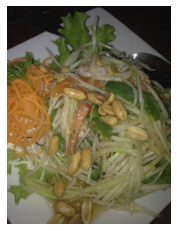

<class 'torch.Tensor'>
['good_for_dinner', 'takes_reservations', 'outdoor_seating', 'restaurant_is_expensive', 'has_alcohol', 'has_table_service', 'ambience_is_classy']
['good_for_dinner', 'takes_reservations', 'outdoor_seating', 'restaurant_is_expensive', 'has_alcohol', 'has_table_service', 'ambience_is_classy']


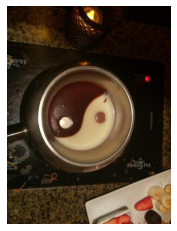

<class 'torch.Tensor'>
['good_for_dinner', 'has_alcohol', 'has_table_service', 'good_for_kids']
['good_for_dinner', 'takes_reservations', 'outdoor_seating', 'restaurant_is_expensive', 'has_alcohol', 'has_table_service']


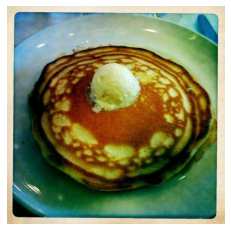

<class 'torch.Tensor'>
['good_for_lunch', 'outdoor_seating', 'has_table_service', 'good_for_kids']
['good_for_lunch', 'outdoor_seating', 'has_table_service', 'good_for_kids']


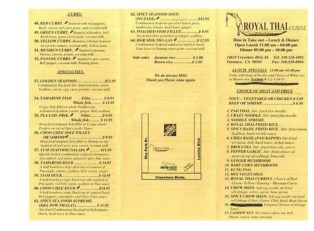

<class 'torch.Tensor'>
['good_for_lunch', 'good_for_dinner', 'outdoor_seating']
['good_for_lunch', 'outdoor_seating', 'good_for_kids']


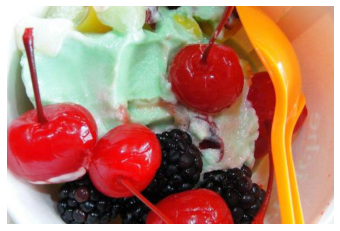

<class 'torch.Tensor'>
['good_for_dinner', 'takes_reservations', 'outdoor_seating', 'has_alcohol', 'has_table_service', 'ambience_is_classy']
['good_for_dinner', 'takes_reservations', 'restaurant_is_expensive', 'has_alcohol', 'has_table_service', 'ambience_is_classy']


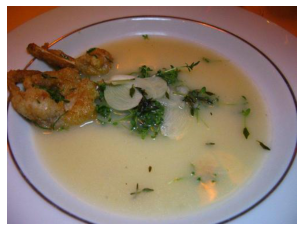

<class 'torch.Tensor'>
['good_for_dinner', 'has_alcohol', 'has_table_service', 'good_for_kids']
['takes_reservations', 'has_alcohol', 'has_table_service']


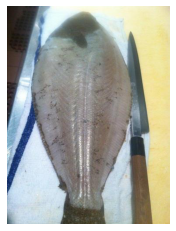

<class 'torch.Tensor'>
['good_for_dinner', 'takes_reservations', 'has_alcohol', 'has_table_service', 'ambience_is_classy', 'good_for_kids']
['good_for_dinner', 'takes_reservations', 'has_alcohol', 'has_table_service', 'ambience_is_classy', 'good_for_kids']


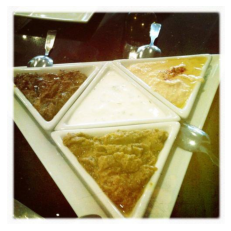

<class 'torch.Tensor'>
['good_for_dinner', 'takes_reservations', 'restaurant_is_expensive', 'has_alcohol', 'has_table_service', 'ambience_is_classy']
['good_for_dinner', 'takes_reservations', 'has_alcohol', 'has_table_service']


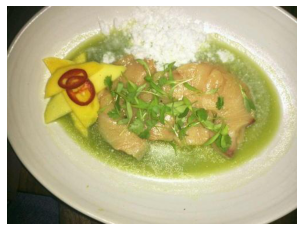

<class 'torch.Tensor'>
['takes_reservations', 'has_alcohol', 'has_table_service', 'good_for_kids']
['outdoor_seating', 'good_for_kids']


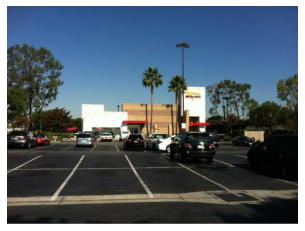

In [38]:
print("Micro F1 : "+str(best[0])+"  Macro F1 : "+str(best[1])+ "     Samples F1 : "+str(best[2]))

model.eval()
label_notation = {0: 'good_for_lunch', 1: 'good_for_dinner', 2: 'takes_reservations',  3: 'outdoor_seating',
                  4: 'restaurant_is_expensive', 5: 'has_alcohol', 6: 'has_table_service', 7: 'ambience_is_classy',
                  8: 'good_for_kids'}
if torch.cuda.is_available():
    model.cuda()
for sample_id in [1,2,3,4,6,7,8,9,10,11]:
    test_img, test_labels = test_dataset[sample_id]
    print(type(test_img))
    test_img = test_img.cuda()
    test_img_path = os.path.join('./train_photos', str(test_dataset.imgs[sample_id])+'.jpg')
    with torch.no_grad():
        raw_pred = model(test_img.unsqueeze(0)).cpu().numpy()[0]
        raw_pred = np.array(raw_pred > 0.5, dtype=float)

    predicted_labels = np.array(dataset_val.classes)[np.argwhere(raw_pred > 0)[:, 0]]
    if not len(predicted_labels):
        predicted_labels = ['no predictions']
    img_labels = np.array(dataset_val.classes)[np.argwhere(test_labels > 0)[:, 0]]
    
    result = [label_notation[p] for p in predicted_labels]
    expected = [label_notation[p] for p in img_labels]
    plt.imshow(Image.open(test_img_path))
    print(result)
    print(expected)
    plt.axis('off')
    plt.show()

['outdoor_seating', 'has_table_service', 'good_for_kids']


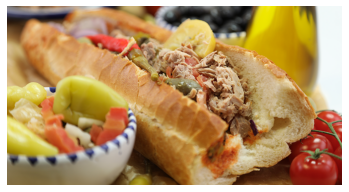

In [59]:

    test_img_path = '../input/lablebi/sandwich.jpg'
    model.eval()
    with torch.no_grad():
        model_result = []
        targets = []
        test_img = Image.open(test_img_path)
        test_img = val_transform(test_img)
        test_img = test_img.to(device)
        raw_pred = model(test_img.unsqueeze(0)).cpu().numpy()[0]
        

    predicted_labels = np.array(dataset_val.classes)[np.argwhere(raw_pred > 0.5)[:, 0]]

    
    result = [label_notation[p] for p in predicted_labels]
    plt.imshow(Image.open(test_img_path))
    print(result)
    plt.axis('off')
    plt.show()

['good_for_dinner', 'takes_reservations', 'outdoor_seating', 'restaurant_is_expensive', 'has_alcohol', 'has_table_service', 'ambience_is_classy']


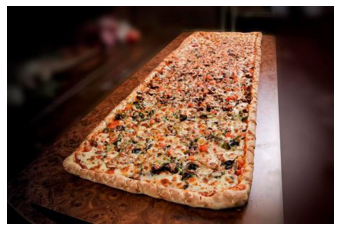

In [61]:
    test_img_path = '../input/lablebi/pizza.jpg'
    model.eval()
    with torch.no_grad():
        model_result = []
        targets = []
        test_img = Image.open(test_img_path)
        test_img = val_transform(test_img)
        test_img = test_img.to(device)
        raw_pred = model(test_img.unsqueeze(0)).cpu().numpy()[0]
        

    predicted_labels = np.array(dataset_val.classes)[np.argwhere(raw_pred > 0.5)[:, 0]]

    
    result = [label_notation[p] for p in predicted_labels]
    plt.imshow(Image.open(test_img_path))
    print(result)
    plt.axis('off')
    plt.show()

['outdoor_seating', 'has_table_service', 'good_for_kids']


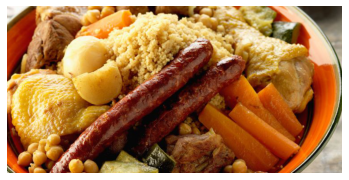

In [62]:
    test_img_path = '../input/lablebi/couscous.jpg'
    model.eval()
    with torch.no_grad():
        model_result = []
        targets = []
        test_img = Image.open(test_img_path)
        test_img = val_transform(test_img)
        test_img = test_img.to(device)
        raw_pred = model(test_img.unsqueeze(0)).cpu().numpy()[0]
        

    predicted_labels = np.array(dataset_val.classes)[np.argwhere(raw_pred > 0.5)[:, 0]]

    
    result = [label_notation[p] for p in predicted_labels]
    plt.imshow(Image.open(test_img_path))
    print(result)
    plt.axis('off')
    plt.show()

['good_for_dinner', 'has_alcohol', 'has_table_service', 'good_for_kids']


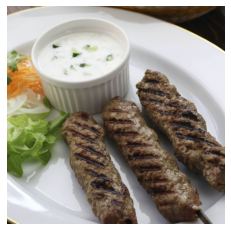

In [63]:
    test_img_path = '../input/lablebi/mechwi.jpg'
    model.eval()
    with torch.no_grad():
        model_result = []
        targets = []
        test_img = Image.open(test_img_path)
        test_img = val_transform(test_img)
        test_img = test_img.to(device)
        raw_pred = model(test_img.unsqueeze(0)).cpu().numpy()[0]
        

    predicted_labels = np.array(dataset_val.classes)[np.argwhere(raw_pred > 0.5)[:, 0]]

    
    result = [label_notation[p] for p in predicted_labels]
    plt.imshow(Image.open(test_img_path))
    print(result)
    plt.axis('off')
    plt.show()